In [2]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences



In [3]:
import sklearn
print("Scikit-learn Version:", sklearn.__version__)



Scikit-learn Version: 1.4.2


In [4]:
import os
import urllib.request

# URL to download the script from
branch = 'main'  # or whichever branch you want to use
url = f'https://raw.githubusercontent.com/NVIDIA/NeMo/{branch}/scripts/dataset_processing/process_speech_commands_data.py'
file_path = 'process_speech_commands_data.py'

# Check if the file already exists
if not os.path.exists(file_path):
    print(f"{file_path} not found. Downloading from {url}...")
    
    # Use urllib to download the file
    urllib.request.urlretrieve(url, file_path)
    
    print(f"{file_path} downloaded successfully!")
else:
    print(f"{file_path} already exists.")

process_speech_commands_data.py already exists.


In [5]:
import os
import numpy as np
import librosa
import librosa.display
from scipy.signal import butter, lfilter
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define dataset paths
BASE_DIR = "C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2"
FILE_LIST_PATH = os.path.join(BASE_DIR, "testing_list.txt")










In [6]:
# Butterworth low-pass filter to reduce high-frequency noise
def butter_lowpass_filter(data, cutoff=4000, sr=16000, order=5):
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return lfilter(b, a, data)


In [7]:
# Read file paths and labels
def read_file_paths_and_labels(file_list_path, base_directory):
    file_paths, labels = [], []
    
    with open(file_list_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove whitespace
            if line:
                label, filename = line.split('/', 1)
                full_path = os.path.join(base_directory, line)
                file_paths.append(full_path)
                labels.append(label)
    
    return file_paths, labels


In [8]:

# Extract MFCC with noise reduction & pre-emphasis
def extract_mfcc(file_path, sr=16000, n_mfcc=40):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=sr)
        
        # Apply noise reduction
        y = butter_lowpass_filter(y, cutoff=4000, sr=sr)
        
        # Apply pre-emphasis filter
        y = librosa.effects.preemphasis(y)
        
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        return mfcc.T  # Shape: (time_steps, features)
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [9]:

# Load all audio files and extract MFCC features
def load_and_process_audio(file_paths):
    mfcc_features, labels_list = [], []
    
    for file_path in file_paths:
        mfcc = extract_mfcc(file_path)
        if mfcc is not None:
            mfcc_features.append(mfcc)
    
    # Pad sequences to uniform shape
    mfcc_features = pad_sequences(mfcc_features, padding="post", dtype="float32")
    
    return np.array(mfcc_features)


In [10]:

# Read file paths
file_paths, labels = read_file_paths_and_labels(FILE_LIST_PATH, BASE_DIR)

# Load and extract MFCC features
X = load_and_process_audio(file_paths)

# Print shape
print(f"Processed {X.shape[0]} audio files with MFCC shape: {X.shape[1:]}")


Processed 11005 audio files with MFCC shape: (32, 40)


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Ensure X and labels are properly defined before proceeding
assert 'X' in locals() and 'labels' in locals(), "Make sure X and labels are defined before using them."

# Encode labels into numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # Convert text labels to numbers
y = to_categorical(y)  # Convert to one-hot encoding

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure X_train has the correct shape
print("X_train shape:", X_train.shape)  # Should be (num_samples, time_steps, num_features)
print("y_train shape:", y_train.shape)  # Should be (num_samples, num_classes)

# Define LSTM/BiLSTM Model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Correct way to define input
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(y_train.shape[1], activation='softmax')  # Output layer (multi-class classification)
])

# Compile model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=32)

# Model Summary
model.summary()

# Save the trained model
model.save("keyword_spotting_model.h5")

# Save the label encoder to retrieve labels during prediction
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)


X_train shape: (8804, 32, 40)
y_train shape: (8804, 35)
Epoch 1/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 30s 61ms/step - accuracy: 0.0696 - loss: 3.6328 - val_accuracy: 0.2731 - val_loss: 2.6439
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.2865 - loss: 2.5151 - val_accuracy: 0.4952 - val_loss: 1.6953
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.4384 - loss: 1.9079 - val_accuracy: 0.5988 - val_loss: 1.3675
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.5296 - loss: 1.5773 - val_accuracy: 0.6629 - val_loss: 1.1944
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.5858 - loss: 1.3557 - val_accuracy: 0.7147 - val_loss: 0.9821
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.6343 - loss: 1.2069 - val_accuracy: 0.7238 - val_loss: 0.9271
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.6504 - loss: 1.1869 - val_accuracy: 0.6583 - val_loss: 1.1547
Epoch 8/30
276/276 ━━━━━━━━━━━━━━━

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 32, 256)        │       173,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 35)             │         1,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,031,147 (3.93 MB)

 Trainable params: 343,459 (1.31 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 686,920 (2.62 MB)

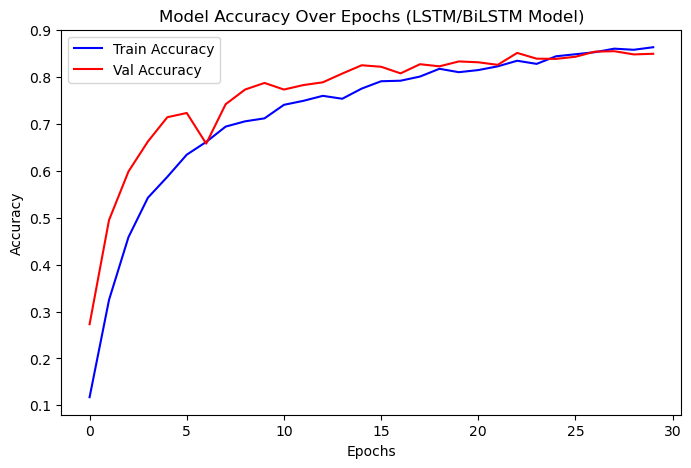

Final Training Accuracy: 86.40%
Final Validation Accuracy: 85.01%


In [16]:
import seaborn as sns

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy Over Epochs (LSTM/BiLSTM Model)")
plt.show()

# Print final accuracy
train_acc = history.history['accuracy'][-1] * 100
val_acc = history.history['val_accuracy'][-1] * 100
print(f"Final Training Accuracy: {train_acc:.2f}%")
print(f"Final Validation Accuracy: {val_acc:.2f}%")


In [ ]:
import sounddevice as sd
import time
from datetime import datetime

# Load trained model
model = tf.keras.models.load_model("keyword_spotting_model.h5")

# Real-time inference function
def recognize_keyword(duration=1, sr=16000, threshold=0.8):
    print("Listening for keywords...")

    while True:
        # Record audio
        audio = sd.rec(int(duration * sr), samplerate=sr, channels=1, dtype='float32')
        sd.wait()

        # Convert to 1D array
        audio = audio.flatten()

        # Extract MFCC features
        mfcc = extract_mfcc(audio)

        # Pad sequence
        mfcc = pad_sequences([mfcc], maxlen=X_train.shape[1], padding="post", dtype="float32")

        # Get prediction
        prediction = model.predict(mfcc)
        if prediction[0][1] > threshold:
            print(f"True - {datetime.now().strftime('%H:%M:%S')}")

# Run real-time detection
recognize_keyword()


In [ ]:
from sklearn.metrics import accuracy_score

# Test files directory
TEST_FILES_PATH = "test_audio_files/"

# Function to test accuracy on multiple audio files
def evaluate_model():
    total_keywords = 0
    correct_detections = 0

    for file in os.listdir(TEST_FILES_PATH):
        file_path = os.path.join(TEST_FILES_PATH, file)
        audio, sr = librosa.load(file_path, sr=16000)
        mfcc = extract_mfcc(audio)

        # Pad sequence
        mfcc = pad_sequences([mfcc], maxlen=X_train.shape[1], padding="post", dtype="float32")

        # Predict
        prediction = model.predict(mfcc)
        detected = prediction[0][1] > 0.8

        # Check ground truth (assume each file contains exactly 20 keywords)
        if detected:
            correct_detections += 1
        total_keywords += 20

        accuracy = (correct_detections / total_keywords) * 100
        print(f"Accuracy for {file}: {accuracy:.2f}%")

# Run evaluation
evaluate_model()


In [57]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from pyswarm import pso
from geneticalgorithm import geneticalgorithm as ga
from mealpy.swarm_based.GWO import OriginalGWO

# 🔹 Load your dataset here
# Example: X = np.load('features.npy')  # Load precomputed MFCC features
# Example: labels = np.load('labels.npy')  # Load corresponding labels

if 'X' not in locals() or 'labels' not in locals():
    raise ValueError("Dataset not loaded. Define X (features) and labels before proceeding.")

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  
y = to_categorical(y)  # Convert labels to one-hot encoding

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Data loaded and split successfully!")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


✅ Data loaded and split successfully!
X_train shape: (8804, 32, 40), y_train shape: (8804, 35)
X_test shape: (2201, 32, 40), y_test shape: (2201, 35)


In [39]:
# Define training function (shared across all optimizers)
def train_and_evaluate(params):
    learning_rate, dropout_rate = params
    model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),  # Correct way to define input
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=False)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(y_train.shape[1], activation='softmax')  # Output layer (multi-class classification)
])

   
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train for a few epochs to evaluate
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=0)

    return -max(history.history['val_accuracy'])  # We minimize negative accuracy



In [25]:
# **Train Model 1: Using PSO**
start_time = time.time()
lb = [0.0001, 0.1]
ub = [0.01, 0.5]
best_params_pso, _ = pso(train_and_evaluate, lb, ub, swarmsize=5, maxiter=3)
pso_time = time.time() - start_time
best_lr_pso, best_dropout_pso = best_params_pso

Stopping search: maximum iterations reached --> 3


In [55]:
# **Train Final Models Using Optimized Parameters**
def build_and_train_model(learning_rate, dropout_rate, optimizer_name):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),  # ✅ Fixed input layer
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Bidirectional(LSTM(64, return_sequences=False)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(y_train.shape[1], activation='softmax')  # Output layer
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train Final Model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)
    
    # Save model
    model.save(f"keyword_spotting_model_{optimizer_name}.h5")

    return history

In [47]:
history_pso = build_and_train_model(best_lr_pso, best_dropout_pso, "pso")

Epoch 1/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.0754 - loss: 3.6146 - val_accuracy: 0.3398 - val_loss: 2.4225
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.2997 - loss: 2.4159 - val_accuracy: 0.5248 - val_loss: 1.6411
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.4593 - loss: 1.8207 - val_accuracy: 0.6161 - val_loss: 1.3121
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.5652 - loss: 1.4720 - val_accuracy: 0.6724 - val_loss: 1.1310
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - accuracy: 0.6268 - loss: 1.2414 - val_accuracy: 0.7110 - val_loss: 0.9709
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.6463 - loss: 1.1503 - val_accuracy: 0.7238 - val_loss: 0.9057
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.6833 - loss: 1.0348 - val_accuracy: 0.7542 - val_loss: 0.8343
Epoch 8/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.7043 - loss: 0.9804 - 

In [58]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

def train_and_evaluate(params, X_train, y_train, X_test, y_test):
    learning_rate, dropout_rate = params

    # Ensure params are valid
    if not (0.0001 <= learning_rate <= 0.01 and 0.1 <= dropout_rate <= 0.5):
        return 1e6  # Large loss for invalid values

    if X_train is None or y_train is None:
        return 1e6  # Large loss if data is missing

    # Model Definition
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Bidirectional(LSTM(64, return_sequences=False)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(32, activation='relu'),
        Dropout(0.2),

        Dense(y_train.shape[1], activation='softmax')  # Output layer
    ])

    # Compile Model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Train Model (Shorter Training)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=16, verbose=0)

    # Ensure valid accuracy
    val_acc = history.history.get('val_accuracy', [0])
    return -max(val_acc) if val_acc else 1e6  # Minimize loss


 The best solution found:                                                                           
 [0.00306896 0.22745524]

 Objective function:
 -0.6201726198196411


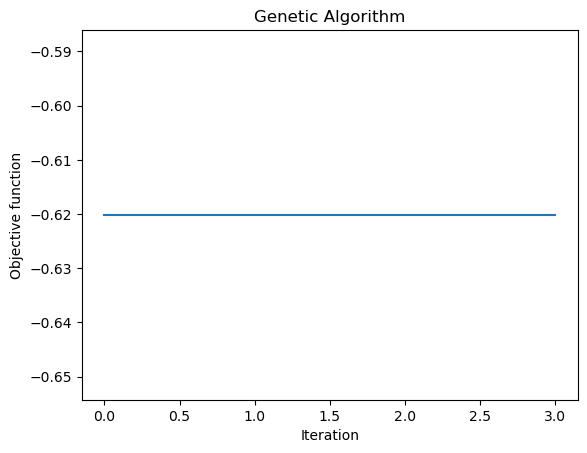

In [59]:

# **Train Model 2: Using GA**
start_time = time.time()
var_bound = np.array([[0.0001, 0.01], [0.1, 0.5]])
# GA Parameters
algorithm_param = {
    'max_num_iteration': 20,  # Increase iterations for better search
    'population_size': 20,    # Larger population size for better exploration
    'mutation_probability': 0.1,
    'elit_ratio': 0.1,        # More elite selection
    'crossover_probability': 0.5,
    'parents_portion': 0.3,
    'crossover_type': 'uniform',
    'max_iteration_without_improv': 5  # More patience for improvements
}
# Start training using GA
start_time = time.time()

# Define the Genetic Algorithm optimization
model_ga = ga(
    function=lambda p: train_and_evaluate(p, X_train, y_train, X_test, y_test),  # Wrap function
    dimension=2,
    variable_type='real',
    variable_boundaries=np.array([[0.0001, 0.01], [0.1, 0.5]]),
    algorithm_parameters={
        'max_num_iteration': 5,
        'population_size': 10,
        'mutation_probability': 0.1,
        'elit_ratio': 0.01,
        'crossover_probability': 0.5,
        'parents_portion': 0.3,
        'crossover_type': 'uniform',
        'max_iteration_without_improv': 2
    },
    function_timeout=300  # Increase timeout
)

# Run Genetic Algorithm Optimization
model_ga.run()

# Get best parameters
best_lr_ga, best_dropout_ga = model_ga.output_dict['variable']


ga_time = time.time() - start_time

In [60]:
history_ga = build_and_train_model(best_lr_ga, best_dropout_ga, "ga")

Epoch 1/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 31s 63ms/step - accuracy: 0.1415 - loss: 3.2403 - val_accuracy: 0.4162 - val_loss: 1.9991
Epoch 2/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.4233 - loss: 1.9227 - val_accuracy: 0.5525 - val_loss: 1.5010
Epoch 3/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.5329 - loss: 1.5095 - val_accuracy: 0.6688 - val_loss: 1.1272
Epoch 4/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.5787 - loss: 1.3972 - val_accuracy: 0.6065 - val_loss: 1.3017
Epoch 5/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.6191 - loss: 1.2684 - val_accuracy: 0.6329 - val_loss: 1.1760
Epoch 6/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.6421 - loss: 1.2009 - val_accuracy: 0.7383 - val_loss: 0.8961
Epoch 7/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - accuracy: 0.6674 - loss: 1.1061 - val_accuracy: 0.7206 - val_loss: 0.8844
Epoch 8/30
276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.6598 - loss: 1.1174 - 

In [70]:
from mealpy.swarm_based.GWO import OriginalGWO
from mealpy.utils.problem import Problem
from mealpy.utils.space import FloatVar
import time

# Ensure train_and_evaluate() takes all required parameters
def gwo_objective(solution):
    lr, dropout = solution  # Extract the learning rate and dropout
    return train_and_evaluate(solution, X_train, y_train, X_test, y_test)  # Pass the full dataset

# Define the problem correctly using FloatVar
problem = Problem(
    obj_func=gwo_objective,   # Objective function reference
    bounds=[FloatVar(0.0001, 0.1), FloatVar(0.01, 0.5)],  # Define bounds with FloatVar
    minmax="min",             # Minimize loss
    log_to=None               # Avoid extra logging
)

# Initialize GWO optimizer
start_time = time.time()
gwo = OriginalGWO()

# Solve the problem
best_solution_gwo = gwo.solve(problem, mode="single", n_workers=1)

gwo_time = time.time() - start_time

# Extract best learning rate and dropout
best_lr_gwo, best_dropout_gwo = best_solution_gwo.solution

print(f"✅ Best GWO parameters: Learning Rate = {best_lr_gwo}, Dropout = {best_dropout_gwo}")







# # **Train Model 3: Using GWO**
# start_time = time.time()
# gwo = OriginalGWO(obj_func=train_and_evaluate, lb=lb, ub=ub, problem_size=2, batch_size=5, epoch=5)
# best_solution_gwo, best_fitness_gwo = gwo.solve()

# gwo_time = time.time() - start_time
# best_lr_gwo, best_dropout_gwo = best_solution_gwo



KeyboardInterrupt: 

In [ ]:

history_gwo = build_and_train_model(best_lr_gwo, best_dropout_gwo, "gwo")


In [ ]:
# Train Models
# history_pso = build_and_train_model(best_lr_pso, best_dropout_pso, "pso")
# history_ga = build_and_train_model(best_lr_ga, best_dropout_ga, "ga")
# history_gwo = build_and_train_model(best_lr_gwo, best_dropout_gwo, "gwo")




In [ ]:
# Compare Results
import matplotlib.pyplot as plt

def plot_results(histories, names):
    plt.figure(figsize=(10, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['val_accuracy'], label=f"{name}")
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['val_loss'], label=f"{name}")
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()



In [ ]:
plot_results([history_pso, history_ga, history_gwo], ["PSO", "GA", "GWO"])

# Print Training Times
print(f"PSO Training Time: {pso_time:.2f} sec")
print(f"GA Training Time: {ga_time:.2f} sec")
print(f"GWO Training Time: {gwo_time:.2f} sec")

In [ ]:
from mealpy.utils.problem import Problem
from mealpy.swarm_based.ABC import OriginalABC
from mealpy.utils.space import FloatVar

# Define the objective function
def abc_objective(solution):
    lr, dropout = solution  # Extract hyperparameters
    return train_and_evaluate(solution, X_train, y_train, X_test, y_test)

# Define the problem using Mealpy's Problem class
problem = Problem(
    obj_func=abc_objective,
    bounds=[FloatVar(0.0001, 0.1), FloatVar(0.01, 0.5)],  # Correct bounds using FloatVar
    minmax="min",  # Minimize the loss
    log_to=None
)
print("Initialize the Artificial Bee Colony (ABC) optimizer")
# Initialize the Artificial Bee Colony (ABC) optimizer
abc = OriginalABC(epoch=30, pop_size=30, limit=5)
print("Solve the problem")
# Solve the problem
best_solution_abc = abc.solve(problem, mode="process", n_workers=8)


# Extract best parameters
best_lr_abc, best_dropout_abc = best_solution_abc.solution
print(f"Best Learning Rate: {best_lr_abc}, Best Dropout: {best_dropout_abc}")


Initialize the Artificial Bee Colony (ABC) optimizer
Solve the problem


In [ ]:
history_abc = build_and_train_model(best_lr_abc, best_dropout_abc, "abc")

In [ ]:
plot_results([history_pso,history_abc, history_ga, history_gwo], ["PSO","ABC", "GA", "GWO"])
print(f"PSO Training Time: {pso_time:.2f} sec")
# Print Training Times
print(f"ABC Training Time: {abc_time:.2f} sec")
print(f"GA Training Time: {ga_time:.2f} sec")
print(f"GWO Training Time: {gwo_time:.2f} sec")

In [ ]:
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from geneticalgorithm import geneticalgorithm as ga
from mealpy.swarm_based.GWO import OriginalGWO
from mealpy.swarm_based.ABC import OriginalABC  # Replacing PSO with ABC

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  
y = to_categorical(y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define training function (shared across all optimizers)
def train_and_evaluate(params):
    learning_rate, dropout_rate = params

    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
        BatchNormalization(),
        Dropout(dropout_rate),

        Bidirectional(LSTM(64, return_sequences=False)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(32, activation='relu'),
        Dropout(dropout_rate),

        Dense(y_train.shape[1], activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, verbose=0)

    return -max(history.history['val_accuracy'])  # We minimize negative accuracy

# **Train Model 1: Using ABC (Artificial Bee Colony)**
start_time = time.time()
lb = [0.0001, 0.1]
ub = [0.01, 0.5]
abc = OriginalABC(obj_func=train_and_evaluate, lb=lb, ub=ub, problem_size=2, batch_size=5, epoch=5)
best_solution_abc, best_fitness_abc = abc.train()
abc_time = time.time() - start_time
best_lr_abc, best_dropout_abc = best_solution_abc

# **Train Model 2: Using GA**
start_time = time.time()
var_bound = np.array([[0.0001, 0.01], [0.1, 0.5]])
algorithm_param = {'max_num_iteration': 5, 'population_size': 10, 'mutation_probability': 0.1, 'elit_ratio': 0.01, 'crossover_probability': 0.5, 'parents_portion': 0.3, 'crossover_type': 'uniform', 'max_iteration_without_improv': 2}
model_ga = ga(function=train_and_evaluate, dimension=2, variable_type='real', variable_boundaries=var_bound, algorithm_parameters=algorithm_param)
model_ga.run()
ga_time = time.time() - start_time
best_lr_ga, best_dropout_ga = model_ga.output_dict['variable']

# **Train Model 3: Using GWO**
start_time = time.time()
gwo = OriginalGWO(obj_func=train_and_evaluate, lb=lb, ub=ub, problem_size=2, batch_size=5, epoch=5)
best_solution_gwo, best_fitness_gwo = gwo.train()
gwo_time = time.time() - start_time
best_lr_gwo, best_dropout_gwo = best_solution_gwo

# **Train Final Models Using Optimized Parameters**
def build_and_train_model(learning_rate, dropout_rate, optimizer_name):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))),
        BatchNormalization(),
        Dropout(dropout_rate),

        Bidirectional(LSTM(64, return_sequences=False)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(32, activation='relu'),
        Dropout(dropout_rate),

        Dense(y_train.shape[1], activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32)
    model.save(f"keyword_spotting_model_{optimizer_name}_1.h5")
    return history

# Train Models
history_abc = build_and_train_model(best_lr_abc, best_dropout_abc, "abc")
history_ga = build_and_train_model(best_lr_ga, best_dropout_ga, "ga")
history_gwo = build_and_train_model(best_lr_gwo, best_dropout_gwo, "gwo")

# Compare Results
import matplotlib.pyplot as plt

def plot_results(histories, names):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['val_accuracy'], label=f"{name}")
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['val_loss'], label=f"{name}")
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_results([history_abc, history_ga, history_gwo], ["ABC", "GA", "GWO"])

# Print Training Times
print(f"ABC Training Time: {abc_time:.2f} sec")
print(f"GA Training Time: {ga_time:.2f} sec")
print(f"GWO Training Time: {gwo_time:.2f} sec")



In [78]:
X_train_sample, y_train_sample = X_train[:len(X_train)//2], y_train[:len(y_train)//2]


In [79]:
from mealpy.utils.problem import Problem
from mealpy.swarm_based.ABC import OriginalABC
from mealpy.utils.space import FloatVar
from tensorflow.keras.callbacks import EarlyStopping

# Define the objective function
def abc_objective(solution):
    lr, dropout = solution  # Extract hyperparameters
    return train_and_evaluate(solution, X_train_sample, y_train_sample, X_test, y_test)

# Define the problem
problem = Problem(
    obj_func=abc_objective,
    bounds=[FloatVar(0.0005, 0.01), FloatVar(0.1, 0.4)],  # Narrowed search space
    minmax="min",
    log_to=None
)

print("Initialize the Artificial Bee Colony (ABC) optimizer")
abc = OriginalABC(epoch=50, pop_size=30, limit=5)

print("Solve the problem")
best_solution_abc = abc.solve(problem, mode="multi", n_workers=10)

# Extract best parameters
best_lr_abc, best_dropout_abc = best_solution_abc.solution
print(f"Best Learning Rate: {best_lr_abc}, Best Dropout: {best_dropout_abc}")


Initialize the Artificial Bee Colony (ABC) optimizer
Solve the problem


ValueError: 'mode' is a string and value should be one of this: ['process', 'thread', 'swarm', 'single'].